![Crisp](img/logo.png)
# <img src="img/Blueprints-Assortment Optimization.png" alt="icon" width="40"/> Assortment Optimization


[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_assortment_optimization.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_assortment_optimization.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_assortment_optimization.ipynb)


> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select Import and choose URL as the import method.
> 4. Paste the notebook's URL and click Import to complete the process.

This notebook demonstrates an approach to product assortment optimization by leveraging store clustering. The steps we propose are as follow:

1. Group similar stores into clusters based on their sales patterns
2. Develop optimized assortments for each cluster based on available space and product performance
3. Apply cluster-level recommendations to individual stores

This approach balances personalization with operational efficiency, making assortment management more practical while still accounting for store-specific characteristics.


## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "777777"
# os.environ["CONNECTOR_ID"] = None

### Run Crisp common notebook

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
import os

if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import dependencies

In [3]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import linprog
from sklearn.cluster import KMeans
import os.path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

%matplotlib inline

## Load necessary data

We will use following tables in this tutorial.

In [4]:
src_project = project
src_dataset = dataset

fact_plan = "exp_normalized_fact_modular_plan"
fact_upc_location = "exp_normalized_fact_modular_upc_location"
fact_mod_product = "exp_normalized_fact_modular_product"
dim_product = "exp_normalized_dim_product"
dim_sub_category = "exp_normalized_dim_product_sub_category"
dim_category = "exp_normalized_dim_product_category"
dim_fineline = "exp_normalized_dim_product_fineline"
dim_store = "exp_normalized_dim_store"
fact_sales = "exp_normalized_fact_sales"

category = "Phones & Tablets"

In [5]:
# Define period in weeks to perform the analysis. This will be used to aggregate the sales data.
weeks = 13  # Last 13 weeks will be used in the analysis.
days_lookback = weeks * 7  # Convert weeks to days.

In [6]:
%%load product_store_data
WITH
  latest_date AS (
  SELECT
    MAX(date_key) AS max_date
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}` ),
  plan AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_plan}` ),
  upc_location AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_upc_location}` ),
  mod_product AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_mod_product}` ),
  product AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_product}` ),
  product_sub_category AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_sub_category}` ),
  product_category AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_category}` ),
  fineline AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_fineline}` ),
  store AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_store}` ),
  sales AS (
  SELECT
    product_id,
    store_id,
    SUM(sales_amount) AS dollar_amount,
    SUM(sales_quantity) AS unit_amount
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}`,
    latest_date
  WHERE
    date_key > DATE_ADD(max_date, INTERVAL -{days_lookback} DAY)
  GROUP BY
    product_id,
    store_id ),
  salesYA AS (
  SELECT
    product_id,
    store_id,
    SUM(sales_amount) AS dollar_amount_YA,
    SUM(sales_quantity) AS unit_amount_YA
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}`,
    latest_date
  WHERE
    date_key > DATE_ADD(max_date, INTERVAL (-{days_lookback}-365) DAY)
    AND date_key < DATE_ADD(max_date, INTERVAL -365 DAY)
  GROUP BY
    product_id,
    store_id )
SELECT
  product.product,
  product.product_id,
  product.product_fineline_id,
  fineline.product_fineline,
  store.store,
  store.store_id,
  store.store_state,
  product_sub_category.product_sub_category,
  product_category.product_category,
  upc_location.position_bottom_coordinate,
  upc_location.position_left_coordinate,
  upc_location.position_depth,
  upc_location.position_width,
  upc_location.position_height,
  mod_product.shelf_capacity_quantity,
  upc_location.total_horizontal_facing_quantity,
  upc_location.total_vertical_facing_quantity,
  product.product_width,
  product.product_height,
  sales.dollar_amount,
  sales.unit_amount,
  salesYA.dollar_amount_YA,
  salesYA.unit_amount_YA
FROM
  plan
JOIN
  upc_location
USING
  (market_id,
    modular_plan_id)
JOIN
  mod_product
USING
  (market_id,
    modular_plan_id,
    product_id)
JOIN
  product
USING
  (product_id)
JOIN
  product_sub_category
USING
  (product_sub_category_id)
JOIN
  product_category
USING
  (product_category_id)
JOIN
  store
USING
  (store_id)
JOIN
  sales
USING
  (product_id,
    store_id)
LEFT JOIN
  salesYA
USING
  (product_id,
    store_id)
JOIN
  fineline
USING
  (product_fineline_id)
WHERE
  (product_category.product_category = '{category}')
  AND ( discontinue_date IS NULL
    OR discontinue_date > (
    SELECT
      max_date
    FROM
      latest_date) )
ORDER BY
  product,
  store

,product,product_id,product_fineline_id,product_fineline,store,store_id,store_state,product_sub_category,product_category,position_bottom_coordinate,...,position_height,shelf_capacity_quantity,total_horizontal_facing_quantity,total_vertical_facing_quantity,product_width,product_height,dollar_amount,unit_amount,dollar_amount_YA,unit_amount_YA
0,LunaBook Pro,124,1,Smartphones,STORE 10225,528560067038876100,MI,Smartphones,Phones & Tablets,27.76,...,9.72,6,1,1,18.15,9.72,21769.37,307,23116.66,326
1,LunaBook Pro,124,1,Smartphones,STORE 10259,759598227039054229,MI,Smartphones,Phones & Tablets,75.77,...,9.72,4,2,1,18.15,9.72,27971.67,347,28455.33,353
2,LunaBook Pro,124,1,Smartphones,STORE 13906,904778860258823374,AR,Smartphones,Phones & Tablets,70.67,...,9.72,3,2,1,18.15,9.72,18032.30,338,17392.10,326
3,LunaBook Pro,124,1,Smartphones,STORE 14506,135452161616194738,OK,Smartphones,Phones & Tablets,11.79,...,9.72,5,1,1,18.15,9.72,28696.72,328,28434.25,325
4,LunaBook Pro,124,1,Smartphones,STORE 14741,646140881333183786,TX,Smartphones,Phones & Tablets,23.09,...,9.72,3,2,1,18.15,9.72,24716.81,347,23149.75,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,LunaTech Verse,120,2,Tablets,STORE 4284,998323681039678085,GA,Tablets,Phones & Tablets,79.27,...,14.14,8,2,1,14.72,14.14,38846.88,477,35996.48,442
422,LunaTech Verse,120,2,Tablets,STORE 4485,179741091848985661,GA,Tablets,Phones & Tablets,12.1,...,14.14,7,2,2,14.72,14.14,8071.18,481,7282.52,434
423,LunaTech Verse,120,2,Tablets,STORE 4686,983645726226578484,FL,Tablets,Phones & Tablets,47.89,...,14.14,7,2,2,14.72,14.14,41050.64,478,39075.40,455
424,LunaTech Verse,120,2,Tablets,STORE 5866,136182763467218002,AL,Tablets,Phones & Tablets,98.12,...,14.14,10,2,2,14.72,14.14,17921.10,470,16243.38,426


In [7]:
# Transform relevant columns to float and drop duplicates
product_store_data = product_store_data.apply(
    pd.to_numeric, errors="ignore"
).drop_duplicates()

product_store_data = product_store_data.fillna(0)

product_store_data

/var/folders/hd/pkq65sv51qn57098r8ccl2380000gn/T/ipykernel_7140/4217059289.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  product_store_data = product_store_data.apply(


,product,product_id,product_fineline_id,product_fineline,store,store_id,store_state,product_sub_category,product_category,position_bottom_coordinate,...,position_height,shelf_capacity_quantity,total_horizontal_facing_quantity,total_vertical_facing_quantity,product_width,product_height,dollar_amount,unit_amount,dollar_amount_YA,unit_amount_YA
0,LunaBook Pro,124,1,Smartphones,STORE 10225,528560067038876100,MI,Smartphones,Phones & Tablets,27.76,...,9.72,6,1,1,18.15,9.72,21769.37,307,23116.66,326
1,LunaBook Pro,124,1,Smartphones,STORE 10259,759598227039054229,MI,Smartphones,Phones & Tablets,75.77,...,9.72,4,2,1,18.15,9.72,27971.67,347,28455.33,353
2,LunaBook Pro,124,1,Smartphones,STORE 13906,904778860258823374,AR,Smartphones,Phones & Tablets,70.67,...,9.72,3,2,1,18.15,9.72,18032.30,338,17392.10,326
3,LunaBook Pro,124,1,Smartphones,STORE 14506,135452161616194738,OK,Smartphones,Phones & Tablets,11.79,...,9.72,5,1,1,18.15,9.72,28696.72,328,28434.25,325
4,LunaBook Pro,124,1,Smartphones,STORE 14741,646140881333183786,TX,Smartphones,Phones & Tablets,23.09,...,9.72,3,2,1,18.15,9.72,24716.81,347,23149.75,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,LunaTech Verse,120,2,Tablets,STORE 4284,998323681039678085,GA,Tablets,Phones & Tablets,79.27,...,14.14,8,2,1,14.72,14.14,38846.88,477,35996.48,442
422,LunaTech Verse,120,2,Tablets,STORE 4485,179741091848985661,GA,Tablets,Phones & Tablets,12.10,...,14.14,7,2,2,14.72,14.14,8071.18,481,7282.52,434
423,LunaTech Verse,120,2,Tablets,STORE 4686,983645726226578484,FL,Tablets,Phones & Tablets,47.89,...,14.14,7,2,2,14.72,14.14,41050.64,478,39075.40,455
424,LunaTech Verse,120,2,Tablets,STORE 5866,136182763467218002,AL,Tablets,Phones & Tablets,98.12,...,14.14,10,2,2,14.72,14.14,17921.10,470,16243.38,426


## Section 1: Store Clustering Methodology

In retail, stores often exhibit similar patterns despite geographic separation. Our clustering approach identifies these natural groupings by analyzing product subcategory sales ammount.

We use K-means clustering with standardized features to group stores with similar sales profiles. This ensures that stores in the same cluster have comparable customer preferences and sales patterns, making them suitable for a common assortment strategy.

The clustering can be customized by:
- Loading pre-defined clusters from a CSV file
- Adjusting the number of clusters based on business requirements
- Modifying the features used for clustering (currently using product subcategory sales)

The resulting clusters form the foundation for our assortment optimization process.

Refer to the clustering notebook for a more detailed implementation [crisp_store_clustering.ipynb](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_store_clustering.ipynb)

In [8]:
# Option 1: Load clusters from a CSV file
# Expected CSV schema:
# store,cluster
# STORE 1047,0
# STORE 1332,1
# ...

cluster_csv_path = "store_clusters.csv"  # Update this path as needed

# Check if the clustering CSV exists
if os.path.exists(cluster_csv_path):
    print(f"Loading store clusters from {cluster_csv_path}")
    store_clusters_df = pd.read_csv(cluster_csv_path)

    # Validate the CSV schema
    required_columns = ["store", "cluster"]
    if not all(col in store_clusters_df.columns for col in required_columns):
        raise ValueError(f"CSV must contain columns: {required_columns}")

    # Create a dictionary mapping stores to clusters
    store_to_cluster = dict(
        zip(store_clusters_df["store"], store_clusters_df["cluster"])
    )

    # Count stores per cluster
    cluster_counts = (
        store_clusters_df.groupby("cluster").size().reset_index(name="count")
    )
    print(f"Loaded {len(cluster_counts)} clusters with {len(store_clusters_df)} stores")

# Option 2: Cluster stores by product_sub_category sales
else:
    print("No cluster file found. Clustering stores by product sub-category sales...")

    # Create a pivot table of store vs product_sub_category sales
    store_category_sales = (
        product_store_data.drop_duplicates(subset=["store", "product_id"])
        .groupby(["store", "product_sub_category"])["dollar_amount"]
        .sum()
        .reset_index()
    )
    store_category_pivot = store_category_sales.pivot(
        index="store", columns="product_sub_category", values="dollar_amount"
    ).fillna(0)

    # Use StandardScaler to normalize the features
    scaler = StandardScaler()
    store_category_scaled = scaler.fit_transform(store_category_pivot)

    # Apply KMeans clustering on scaled data
    n_clusters = 5  # Adjust this number based on your business needs
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(store_category_scaled)

    # Create a dictionary mapping stores to clusters
    store_to_cluster = dict(zip(store_category_pivot.index, clusters))

    # Create a DataFrame for potential export
    store_clusters_df = pd.DataFrame(
        {"store": store_category_pivot.index, "cluster": clusters}
    )

    # Examine the clustering results
    print(f"Created {n_clusters} store clusters")
    cluster_counts = (
        store_clusters_df.groupby("cluster").size().reset_index(name="count")
    )
    print(cluster_counts)

    # Optionally save the clusters for future use
    # store_clusters_df.to_csv('store_clusters.csv', index=False)

# Add cluster information to the main product_store_data DataFrame
product_store_data["cluster"] = product_store_data["store"].map(store_to_cluster)

product_store_data[["store", "cluster", "product", "dollar_amount"]].head()

No cluster file found. Clustering stores by product sub-category sales...
Created 5 store clusters
   cluster  count
0        0      3
1        1      6
2        2      5
3        3      9
4        4      7


,store,cluster,product,dollar_amount
0,STORE 10225,4,LunaBook Pro,21769.37
1,STORE 10259,4,LunaBook Pro,27971.67
2,STORE 13906,2,LunaBook Pro,18032.30
3,STORE 14506,2,LunaBook Pro,28696.72
4,STORE 14741,1,LunaBook Pro,24716.81


## Section 2: Calculate Sales Metrics and Clean Data
This section cleans the data by removing products with negative sales and calculates various sales metrics such as dollar velocity, unit velocity and price per unit.

In [9]:
# Define sales data frame
product_store_sales = (
    product_store_data.drop_duplicates(subset=["store", "product_id"])
    .groupby(
        ["store", "product", "product_sub_category", "product_fineline", "store_state"]
    )[["unit_amount", "dollar_amount", "unit_amount_YA", "dollar_amount_YA"]]
    .sum()
    .reset_index()
)

# Find dollar_velocity defined as: $ sales / store / week
product_store_sales["dollar_velocity"] = product_store_sales["dollar_amount"] / weeks

# Find dollar_velocity YA defined as: $ sales / store / week
product_store_sales["dollar_velocity_YA"] = (
    product_store_sales["dollar_amount_YA"] / weeks
)

# Find quantity_velocity defined as: unit sales / store / week
product_store_sales["unit_velocity"] = product_store_sales["unit_amount"] / weeks

# Find quantity_velocity YA defined as: unit sales / store / week
product_store_sales["unit_velocity_YA"] = product_store_sales["unit_amount_YA"] / weeks

# Clean up the data by removing products with negative sales
product_store_sales = product_store_sales[
    (product_store_sales["dollar_amount"] > 0)
    & (product_store_sales["unit_amount"] > 0)
]

# Calculate price per unit
product_store_sales["price_per_unit"] = (
    product_store_sales["dollar_amount"] / product_store_sales["unit_amount"]
)

product_store_sales

,store,product,product_sub_category,product_fineline,store_state,unit_amount,dollar_amount,unit_amount_YA,dollar_amount_YA,dollar_velocity,dollar_velocity_YA,unit_velocity,unit_velocity_YA,price_per_unit
0,STORE 10225,LunaBook Pro,Smartphones,Smartphones,MI,307,21769.37,326,23116.66,1674.566923,1778.204615,23.615385,25.076923,70.91
1,STORE 10225,LunaPhone Axis,Smartphones,Smartphones,MI,184,14835.92,211,17012.93,1141.224615,1308.686923,14.153846,16.230769,80.63
2,STORE 10225,LunaPhone Ion,Smartphones,Smartphones,MI,114,7388.34,129,8360.49,568.333846,643.114615,8.769231,9.923077,64.81
3,STORE 10225,LunaPhone Nova,Smartphones,Smartphones,MI,408,21730.08,462,24606.12,1671.544615,1892.778462,31.384615,35.538462,53.26
4,STORE 10225,LunaPhone Pulse,Smartphones,Smartphones,MI,360,16876.80,342,16032.96,1298.215385,1233.304615,27.692308,26.307692,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,STORE 660,LunaTab X,Tablets,Tablets,NY,418,25397.68,437,26552.12,1953.667692,2042.470769,32.153846,33.615385,60.76
422,STORE 660,LunaTech Induction Cooktop,Tablets,Tablets,NY,284,21427.80,267,20145.15,1648.292308,1549.626923,21.846154,20.538462,75.45
423,STORE 660,LunaTech Pad,Tablets,Tablets,NY,299,8563.36,299,8563.36,658.720000,658.720000,23.0,23.0,28.64
424,STORE 660,LunaTech Slate,Tablets,Tablets,NY,191,16529.14,227,19644.58,1271.472308,1511.121538,14.692308,17.461538,86.54


Visualize top and bottom performing products across all stores

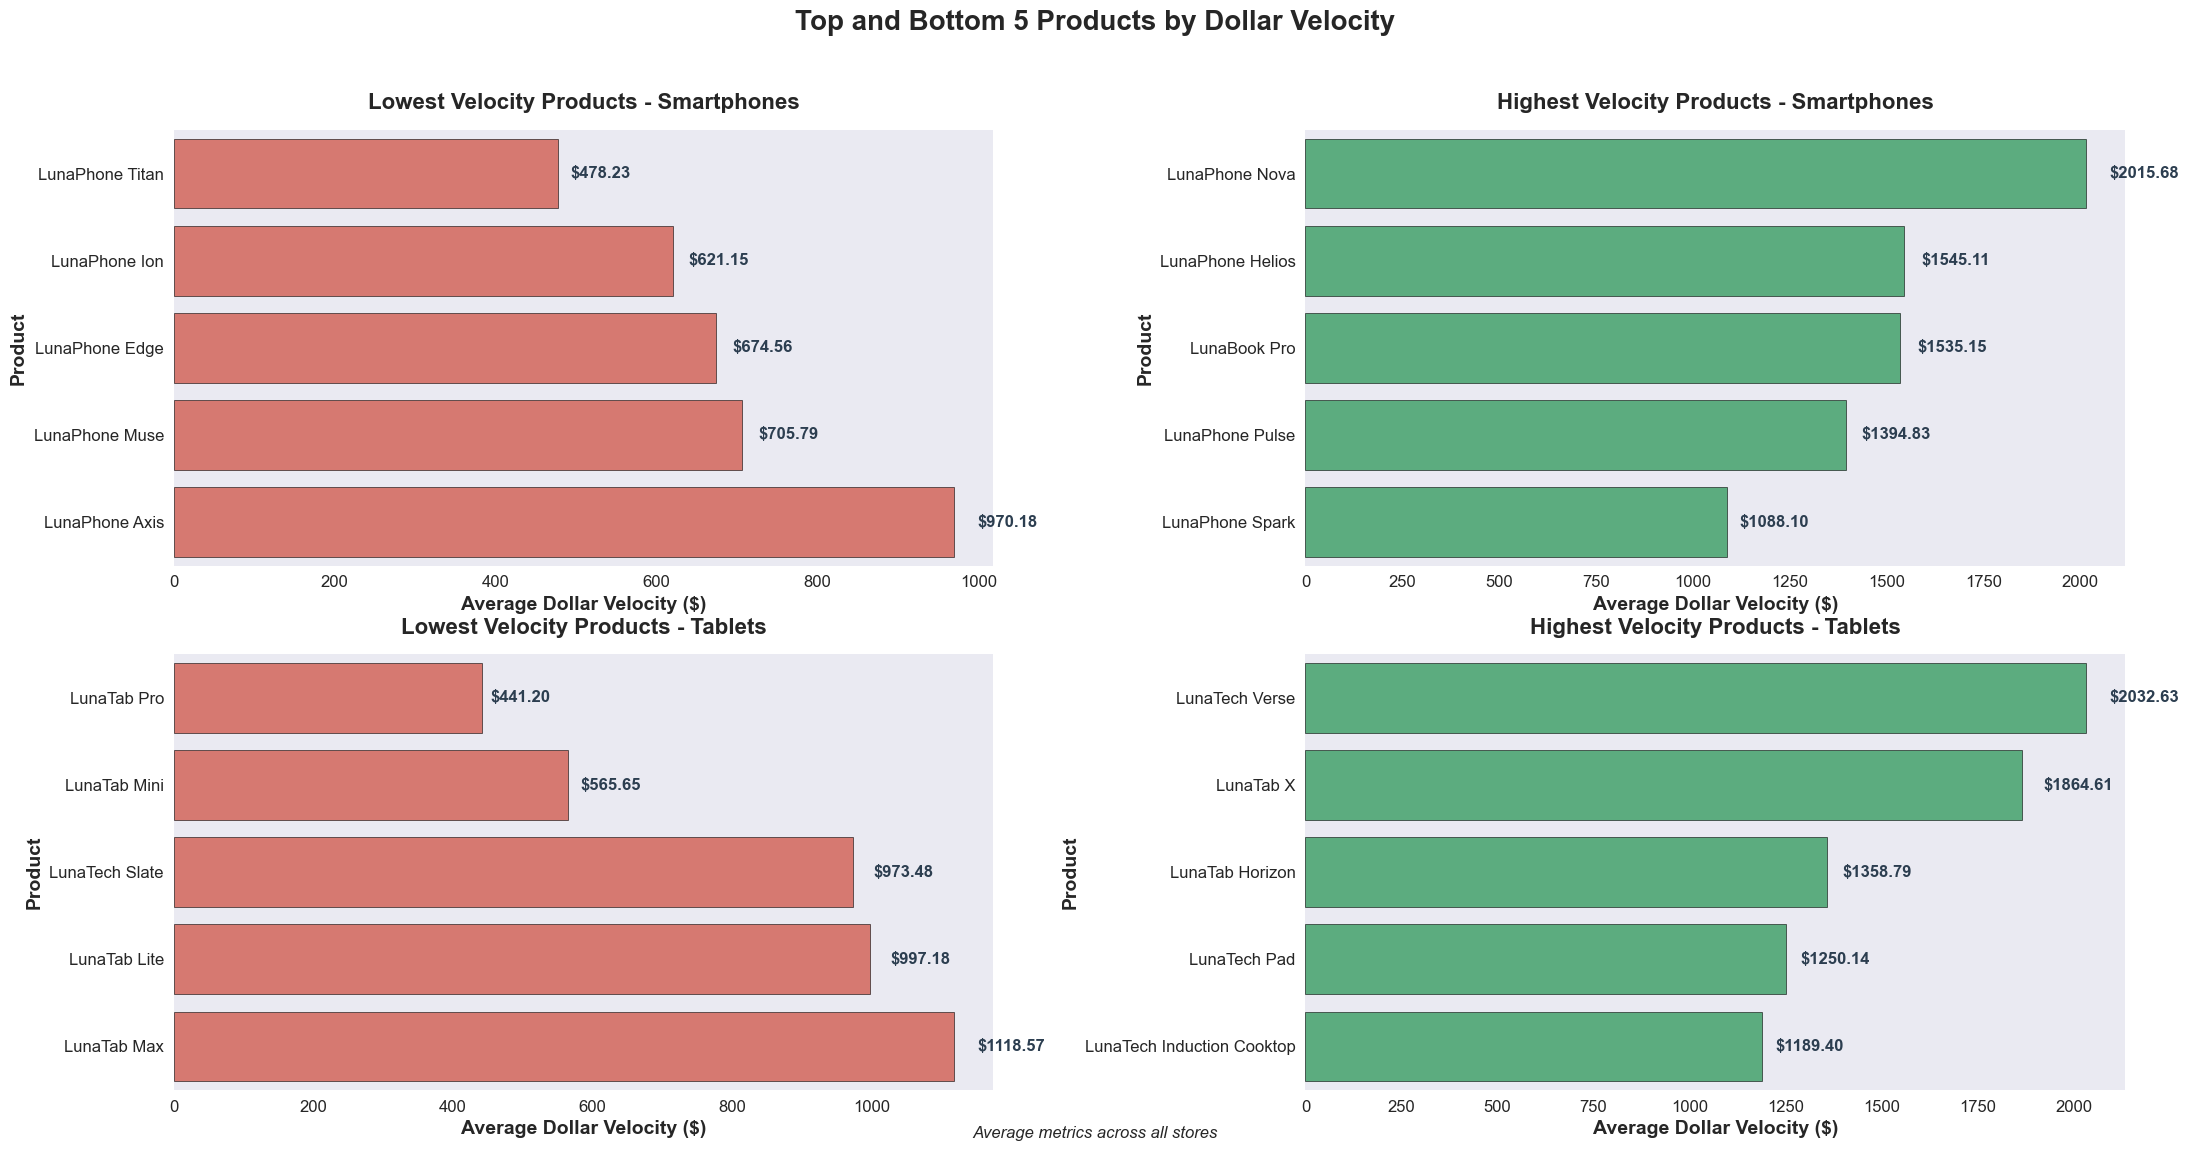

In [10]:
plt.style.use("seaborn-v0_8")
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans"]
mpl.rcParams["axes.grid"] = False

# Calculate average velocity by product and subcategory across all stores
product_velocity_by_subcategory = (
    product_store_sales.groupby(["product", "product_sub_category"])
    .agg({"dollar_velocity": "mean"})
    .reset_index()
)

# Get unique subcategories
subcategories = product_velocity_by_subcategory["product_sub_category"].unique()

# Create subplot layout
n_subcategories = len(subcategories)
fig, axes = plt.subplots(n_subcategories, 2, figsize=(22, 6 * n_subcategories))

# If there's only one subcategory, wrap axes in a list to make indexing work
if n_subcategories == 1:
    axes = np.array([axes])

# Set color palette
bottom_color = "#E74C3C"  # dark red
top_color = "#27AE60"  # green

for i, subcategory in enumerate(subcategories):
    # Filter data for this subcategory
    subcategory_data = product_velocity_by_subcategory[
        product_velocity_by_subcategory["product_sub_category"] == subcategory
    ]

    # Sort by dollar velocity
    subcategory_data = subcategory_data.sort_values("dollar_velocity")

    # Get top and bottom 5 products
    bottom_5 = subcategory_data.head(5)
    top_5 = subcategory_data.tail(5)

    # Plot bottom 5
    bars_bottom = sns.barplot(
        x="dollar_velocity",
        y="product",
        data=bottom_5,
        ax=axes[i, 0],
        color=bottom_color,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
    )

    # Customize the left plot
    axes[i, 0].set_title(
        f"Lowest Velocity Products - {subcategory}",
        fontsize=16,
        fontweight="bold",
        pad=15,
    )
    axes[i, 0].set_xlabel("Average Dollar Velocity ($)", fontsize=14, fontweight="bold")
    axes[i, 0].set_ylabel("Product", fontsize=14, fontweight="bold")
    axes[i, 0].tick_params(axis="both", labelsize=12)
    axes[i, 0].grid(False)  # Explicitly turn off all grid lines

    # Add velocity values at the end of each bar
    for j, p in enumerate(bars_bottom.patches):
        velocity = bottom_5.iloc[j]["dollar_velocity"]
        width = p.get_width()
        axes[i, 0].text(
            width + width * 0.03,
            p.get_y() + p.get_height() / 2,
            f"${velocity:.2f}",
            va="center",
            fontsize=12,
            color="#2C3E50",
            fontweight="bold",
        )

    # Plot top 5 (reversed to show highest at the top)
    bars_top = sns.barplot(
        x="dollar_velocity",
        y="product",
        data=top_5.iloc[::-1],
        ax=axes[i, 1],
        color=top_color,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
    )

    # Customize the right
    axes[i, 1].set_title(
        f"Highest Velocity Products - {subcategory}",
        fontsize=16,
        fontweight="bold",
        pad=15,
    )
    axes[i, 1].set_xlabel("Average Dollar Velocity ($)", fontsize=14, fontweight="bold")
    axes[i, 1].set_ylabel("Product", fontsize=14, fontweight="bold")
    axes[i, 1].tick_params(axis="both", labelsize=12)
    axes[i, 1].grid(False)

    # Add velocity values at the end of each bar
    for j, p in enumerate(bars_top.patches):
        velocity = top_5.iloc[::-1].iloc[j]["dollar_velocity"]
        width = p.get_width()
        axes[i, 1].text(
            width + width * 0.03,
            p.get_y() + p.get_height() / 2,
            f"${velocity:.2f}",
            va="center",
            fontsize=12,
            color="#2C3E50",
            fontweight="bold",
        )


plt.tight_layout()

plt.subplots_adjust(top=0.85, bottom=0.05)

fig.suptitle(
    "Top and Bottom 5 Products by Dollar Velocity",
    fontsize=20,
    fontweight="bold",
    y=0.95,
)

plt.figtext(
    0.5,
    0.01,
    "Average metrics across all stores",
    ha="center",
    fontsize=12,
    fontstyle="italic",
)

plt.show()

## Section 3: Estimate Future Product Store Level Velocity

### Section 3.1: Existing items
 This section estimates the future product store level velocity for existing items in the store.
 It calculates the dollar and unit velocity for the current year and prior year, computes growth and growth rates, and predicts future velocities.
 Adjustments are made for items with zero sales in the prior year, and a flag is added to mark existing products.

In [11]:
# Find the dollar velocity of items per store per week for the current year and prior year
product_store_velocity = (
    product_store_sales[
        [
            "store",
            "product",
            "product_sub_category",
            "product_fineline",
            "store_state",
            "dollar_velocity",
            "unit_velocity",
            "dollar_velocity_YA",
            "unit_velocity_YA",
        ]
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)

# Calculate growth and growth rate for dollar and unit velocity
product_store_velocity["dollar_growth"] = (
    product_store_velocity["dollar_velocity"]
    - product_store_velocity["dollar_velocity_YA"]
)
product_store_velocity["unit_growth"] = (
    product_store_velocity["unit_velocity"] - product_store_velocity["unit_velocity_YA"]
)
product_store_velocity["dollar_growth_rate"] = (
    product_store_velocity["dollar_growth"]
    / product_store_velocity["dollar_velocity_YA"]
)
product_store_velocity["unit_growth_rate"] = (
    product_store_velocity["unit_growth"] / product_store_velocity["unit_velocity_YA"]
)

# Calculate predicted dollar velocity
product_store_velocity["predicted_dollar_velocity"] = np.where(
    product_store_velocity["dollar_growth"] >= 0,
    product_store_velocity["dollar_velocity"] + product_store_velocity["dollar_growth"],
    product_store_velocity["dollar_velocity"]
    * (1.0 + product_store_velocity["dollar_growth_rate"]),
)

# Calculate predicted unit velocity
product_store_velocity["predicted_unit_velocity"] = np.where(
    product_store_velocity["unit_growth"] >= 0,
    product_store_velocity["unit_velocity"] + product_store_velocity["unit_growth"],
    product_store_velocity["unit_velocity"]
    * (1.0 + product_store_velocity["unit_growth_rate"]),
)

# Adjust predicted dollar velocity for items with zero sales in the prior year
product_store_velocity["predicted_dollar_velocity"] = np.where(
    product_store_velocity["dollar_velocity_YA"] == 0,
    product_store_velocity["dollar_velocity"],
    product_store_velocity["predicted_dollar_velocity"],
)

# Adjust predicted unit velocity for items with zero sales in the prior year
product_store_velocity["predicted_unit_velocity"] = np.where(
    product_store_velocity["unit_velocity_YA"] == 0,
    product_store_velocity["unit_velocity"],
    product_store_velocity["predicted_unit_velocity"],
)

# Clean the table only with meaningful columns
product_store_velocity = product_store_velocity[
    [
        "store",
        "product",
        "product_sub_category",
        "product_fineline",
        "store_state",
        "predicted_dollar_velocity",
        "predicted_unit_velocity",
    ]
]

# Add flag to mark existing products
product_store_velocity["existing_product"] = 1

product_store_velocity

,store,product,product_sub_category,product_fineline,store_state,predicted_dollar_velocity,predicted_unit_velocity,existing_product
0,STORE 10225,LunaBook Pro,Smartphones,Smartphones,MI,1576.969464,22.239028,1
1,STORE 10225,LunaPhone Axis,Smartphones,Smartphones,MI,995.191134,12.342690,1
2,STORE 10225,LunaPhone Ion,Smartphones,Smartphones,MI,502.248515,7.749553,1
3,STORE 10225,LunaPhone Nova,Smartphones,Smartphones,MI,1476.169271,27.716284,1
4,STORE 10225,LunaPhone Pulse,Smartphones,Smartphones,MI,1363.126154,29.076923,1
...,...,...,...,...,...,...,...,...
421,STORE 660,LunaTab X,Tablets,Tablets,NY,1868.725619,30.755853,1
422,STORE 660,LunaTech Induction Cooktop,Tablets,Tablets,NY,1746.957692,23.153846,1
423,STORE 660,LunaTech Pad,Tablets,Tablets,NY,658.720000,23.000000,1
424,STORE 660,LunaTech Slate,Tablets,Tablets,NY,1069.829122,12.362250,1


### Section 3.2: Estimate Product Store Level Velocity for Non-Existing Items

This section uses a model to predict sales for non-existing items in the store.
It calculates the velocities for each subcategory in each store, prepares the data for modeling, and uses a Random Forest Regressor to predict the velocities.


In [12]:
# Calculate the total velocities for each subcategory in each store
total_velocities = (
    product_store_velocity.groupby(["store", "product_sub_category"])
    .agg({"predicted_unit_velocity": "sum"})
    .reset_index()
)

# Rename columns for clarity
total_velocities.rename(
    columns={"predicted_unit_velocity": "total_unit_velocity"}, inplace=True
)

# Pivot the velocities to have subcategories as columns
total_velocities_pivot = total_velocities.pivot_table(
    index="store", columns="product_sub_category", values="total_unit_velocity"
).reset_index()

# Replace NaN values with 0 in the pivoted DataFrame
total_velocities_pivot.replace(np.nan, 0, inplace=True)

# Create the final model_data DataFrame with the required columns
model_data = product_store_velocity[
    ["store", "product", "store_state", "predicted_unit_velocity"]
]

# Merge velocities with model_data
model_data = model_data.merge(total_velocities_pivot, on="store", how="left")

model_data

,store,product,store_state,predicted_unit_velocity,Smartphones,Tablets
0,STORE 10225,LunaBook Pro,MI,22.239028,107.509093,143.940191
1,STORE 10225,LunaPhone Axis,MI,12.342690,107.509093,143.940191
2,STORE 10225,LunaPhone Ion,MI,7.749553,107.509093,143.940191
3,STORE 10225,LunaPhone Nova,MI,27.716284,107.509093,143.940191
4,STORE 10225,LunaPhone Pulse,MI,29.076923,107.509093,143.940191
...,...,...,...,...,...,...
421,STORE 660,LunaTab X,NY,30.755853,123.549990,184.922419
422,STORE 660,LunaTech Induction Cooktop,NY,23.153846,123.549990,184.922419
423,STORE 660,LunaTech Pad,NY,23.000000,123.549990,184.922419
424,STORE 660,LunaTech Slate,NY,12.362250,123.549990,184.922419


##### We will create a model to predict product store level sales for all possible combinations of items.

In [13]:
# Create a DataFrame with all possible store-product combinations
stores = model_data["store"].unique()
products = model_data["product"].unique()
store_product_combinations = pd.MultiIndex.from_product(
    [stores, products], names=["store", "product"]
).to_frame(index=False)

# Merge with model_data to get the features for each combination
prediction_data = store_product_combinations.merge(
    model_data.drop(columns=["product", "predicted_unit_velocity"]).drop_duplicates(),
    on=["store"],
    how="left",
)

# Initialize a DataFrame to store the combined predictions
combined_predictions = pd.DataFrame()

In [14]:
for product in products:
    # Filter the data for the current product
    product_data = model_data[model_data["product"] == product]
    X_product = product_data.drop(
        columns=["store", "product", "predicted_unit_velocity"]
    )
    y_product = product_data["predicted_unit_velocity"]

    # Identify categorical and numerical columns for the current product
    categorical_cols = X_product.select_dtypes(include=["object", "category"]).columns
    numerical_cols = X_product.select_dtypes(include=["number"]).columns

    # Preprocessing for numerical data
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )

    # Fit and transform the data
    X_product = preprocessor.fit_transform(X_product)

    # Run a random forest regressor to predict the dollar and unit velocity
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_product, y_product)

    # Find the prediction set of features
    prediction_product_data = prediction_data[prediction_data["product"] == product]
    X_prediction = prediction_product_data.drop(columns=["store", "product"])
    X_prediction = preprocessor.transform(X_prediction)

    # Predict the dollar and unit velocity
    y_pred = rf.predict(X_prediction)

    # Store the predictions in the combined DataFrame
    product_predictions = pd.DataFrame(y_pred, columns=["predicted_unit_velocity"])
    product_predictions["product"] = product
    product_predictions["store"] = prediction_product_data[
        "store"
    ].values  # Add store column
    combined_predictions = pd.concat(
        [combined_predictions, product_predictions], ignore_index=True
    )

In [15]:
# Merge the price per unit with the combined predictions
price = (
    product_store_sales.groupby(["product"])["price_per_unit"].median().reset_index()
)
combined_predictions = combined_predictions.merge(price, on=["product"], how="left")

# Find the predicted dollar velocity
combined_predictions["predicted_dollar_velocity"] = (
    combined_predictions["predicted_unit_velocity"]
    * combined_predictions["price_per_unit"]
)

combined_predictions

,predicted_unit_velocity,product,store,price_per_unit,predicted_dollar_velocity
0,23.328757,LunaBook Pro,STORE 10225,68.32,1593.82067
1,25.575998,LunaBook Pro,STORE 10259,68.32,1747.352167
2,26.595780,LunaBook Pro,STORE 13906,68.32,1817.02366
3,24.899808,LunaBook Pro,STORE 13971,68.32,1701.154904
4,26.083558,LunaBook Pro,STORE 14506,68.32,1782.02868
...,...,...,...,...,...
595,30.752432,LunaTab X,STORE 4485,60.76,1868.51774
596,29.499455,LunaTab X,STORE 4686,60.76,1792.38686
597,34.115931,LunaTab X,STORE 5866,60.76,2072.88394
598,32.020603,LunaTab X,STORE 6316,60.76,1945.57186


In [16]:
# Merge combined_predictions with product_store_velocity to get the updated predicted velocities
updated_predictions = combined_predictions.merge(
    product_store_velocity[
        ["store", "product", "predicted_dollar_velocity", "predicted_unit_velocity"]
    ],
    on=["store", "product"],
    how="left",
    suffixes=("", "_new"),
)

# Replace the predicted velocities with the new values where they exist
updated_predictions["predicted_dollar_velocity"] = updated_predictions[
    "predicted_dollar_velocity_new"
].combine_first(updated_predictions["predicted_dollar_velocity"])
updated_predictions["predicted_unit_velocity"] = updated_predictions[
    "predicted_unit_velocity_new"
].combine_first(updated_predictions["predicted_unit_velocity"])

# Drop the temporary columns
updated_predictions = updated_predictions.drop(
    columns=["predicted_dollar_velocity_new", "predicted_unit_velocity_new"]
)

updated_predictions

,predicted_unit_velocity,product,store,price_per_unit,predicted_dollar_velocity
0,22.239028,LunaBook Pro,STORE 10225,68.32,1576.969464
1,26.238614,LunaBook Pro,STORE 10259,68.32,2115.094681
2,26.923077,LunaBook Pro,STORE 13906,68.32,1436.346154
3,24.899808,LunaBook Pro,STORE 13971,68.32,1701.154904
4,25.461538,LunaBook Pro,STORE 14506,68.32,2227.63
...,...,...,...,...,...
595,30.752432,LunaTab X,STORE 4485,60.76,1868.51774
596,27.086318,LunaTab X,STORE 4686,60.76,2156.883523
597,35.076923,LunaTab X,STORE 5866,60.76,2654.270769
598,30.864425,LunaTab X,STORE 6316,60.76,888.89545


### Section 3.3: Cluster-Level Data Aggregation
After establishing store clusters, we aggregate store-level data to create cluster profiles based on **Sales metrics**

In [17]:
updated_predictions["cluster"] = updated_predictions["store"].map(store_to_cluster)
updated_cluster_predictions = (
    updated_predictions.groupby(["cluster", "product"])
    .agg(
        {
            "predicted_dollar_velocity": "mean",
            "predicted_unit_velocity": "mean",
            "price_per_unit": "mean",
        }
    )
    .reset_index()
)

updated_cluster_predictions

,cluster,product,predicted_dollar_velocity,predicted_unit_velocity,price_per_unit
0,0,LunaBook Pro,1585.435895,23.206029,68.32
1,0,LunaPhone Axis,1167.887933,17.971708,65.665
2,0,LunaPhone Edge,762.195876,12.813208,65.22
3,0,LunaPhone Helios,884.003066,31.265694,37.54
4,0,LunaPhone Ion,395.707058,8.171224,60.61
...,...,...,...,...,...
95,4,LunaTab X,1745.566256,31.623568,60.76
96,4,LunaTech Induction Cooktop,908.725334,20.551560,46.31
97,4,LunaTech Pad,1205.235125,22.909116,53.25
98,4,LunaTech Slate,990.278336,17.528198,61.22


Visualize top and bottom performers by cluster

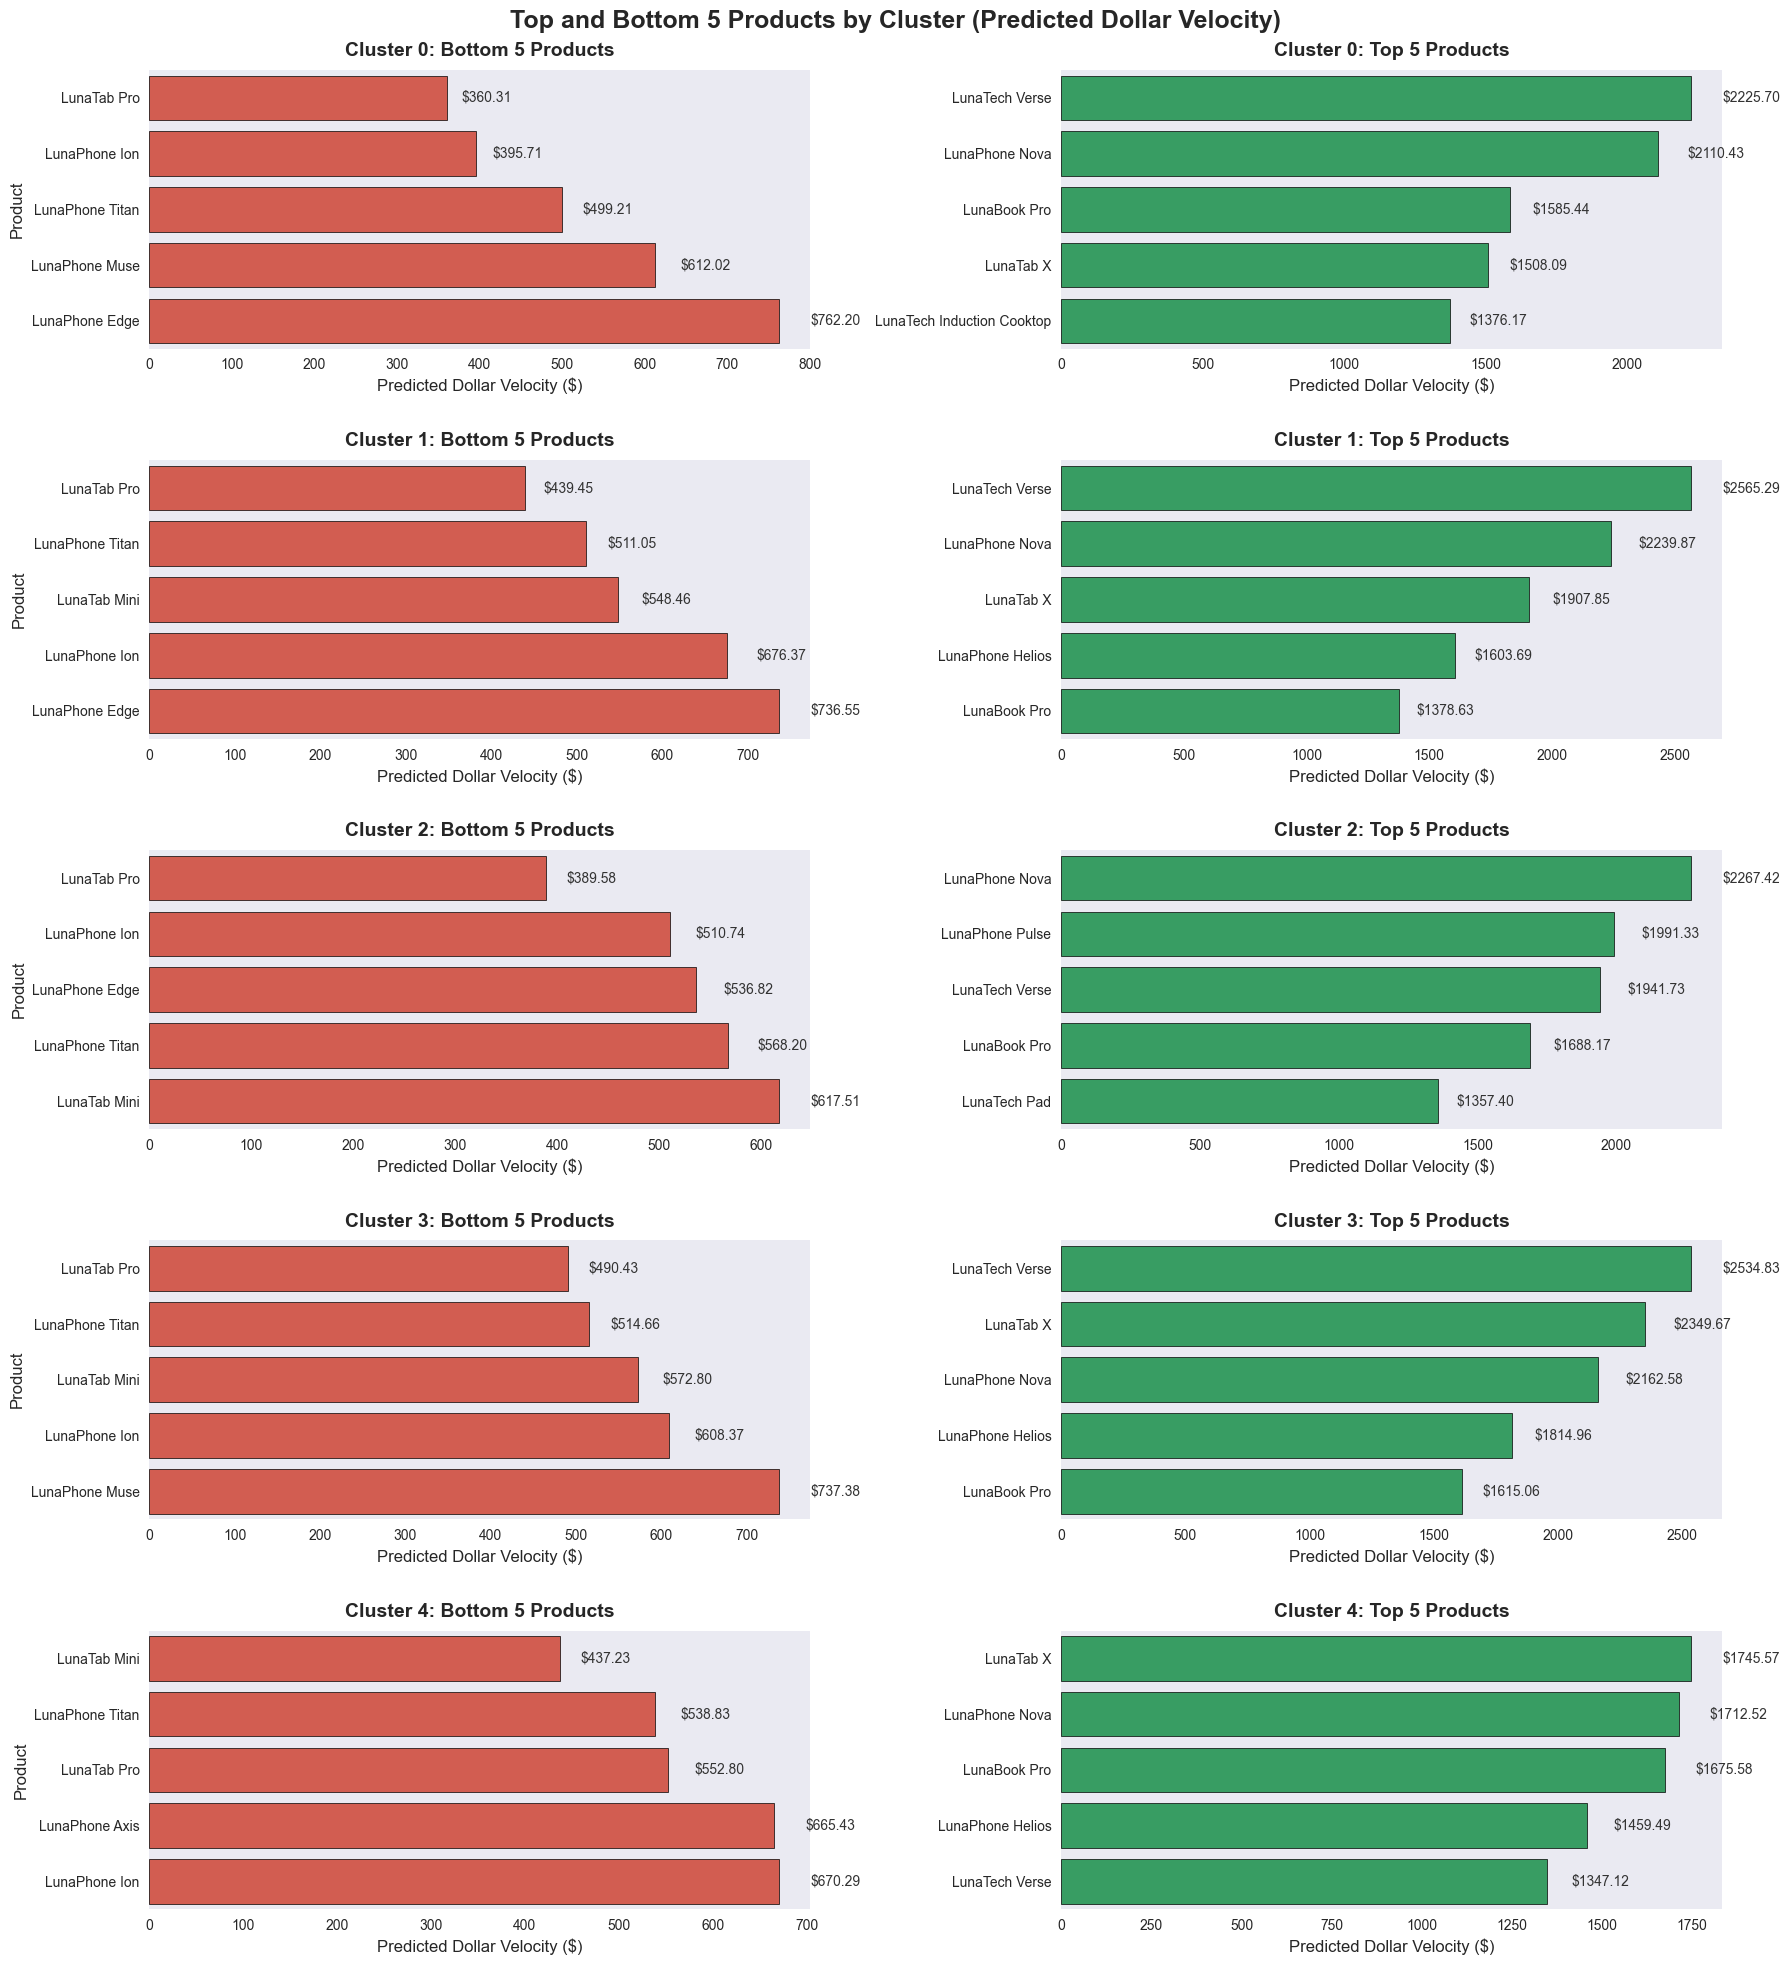

In [18]:
plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams.update({"axes.grid": False})

# Get unique clusters
clusters = updated_cluster_predictions["cluster"].unique()
num_clusters = len(clusters)

# Create the figure with subplots (two columns for each cluster)
fig, axes = plt.subplots(num_clusters, 2, figsize=(18, 4 * num_clusters))

# Ensure axes is always a 2D array
if num_clusters == 1:
    axes = np.array([axes])

# Set colors for bottom and top products
bottom_color = "#E74C3C"  # Dark red
top_color = "#27AE60"  # Green

# For each cluster, create subplots showing bottom 5 and top 5 products
for i, cluster_id in enumerate(sorted(clusters)):
    # Filter data for this cluster
    cluster_data = updated_cluster_predictions[
        updated_cluster_predictions["cluster"] == cluster_id
    ]

    # Sort by predicted dollar velocity
    cluster_data_sorted = cluster_data.sort_values("predicted_dollar_velocity")

    # Get bottom 5 and top 5 products
    bottom_5 = cluster_data_sorted.head(5)
    top_5 = cluster_data_sorted.tail(5)

    # Plot bottom 5
    bars_bottom = sns.barplot(
        x="predicted_dollar_velocity",
        y="product",
        data=bottom_5,
        ax=axes[i, 0],
        color=bottom_color,
        edgecolor="black",
        linewidth=0.5,
    )

    # Plot top 5 (reversed to show highest at the top)
    bars_top = sns.barplot(
        x="predicted_dollar_velocity",
        y="product",
        data=top_5.iloc[::-1],
        ax=axes[i, 1],
        color=top_color,
        edgecolor="black",
        linewidth=0.5,
    )

    # Customize bottom 5 plot
    axes[i, 0].set_title(
        f"Cluster {cluster_id}: Bottom 5 Products",
        fontsize=14,
        fontweight="bold",
        pad=10,
    )
    axes[i, 0].set_xlabel("Predicted Dollar Velocity ($)", fontsize=12)
    axes[i, 0].set_ylabel("Product", fontsize=12)
    axes[i, 0].grid(False)

    # Add dollar velocity values for bottom 5
    for j, p in enumerate(bars_bottom.patches):
        velocity = bottom_5.iloc[j]["predicted_dollar_velocity"]
        width = p.get_width()
        axes[i, 0].text(
            width + width * 0.05,
            p.get_y() + p.get_height() / 2,
            f"${velocity:.2f}",
            va="center",
            fontsize=10,
            color="#333333",
        )

    # Customize top 5 plot
    axes[i, 1].set_title(
        f"Cluster {cluster_id}: Top 5 Products", fontsize=14, fontweight="bold", pad=10
    )
    axes[i, 1].set_xlabel("Predicted Dollar Velocity ($)", fontsize=12)
    axes[i, 1].set_ylabel("", fontsize=12)  # No need for y label on right plot
    axes[i, 1].grid(False)

    # Add dollar velocity values for top 5
    for j, p in enumerate(bars_top.patches):
        velocity = top_5.iloc[::-1].iloc[j]["predicted_dollar_velocity"]
        width = p.get_width()
        axes[i, 1].text(
            width + width * 0.05,
            p.get_y() + p.get_height() / 2,
            f"${velocity:.2f}",
            va="center",
            fontsize=10,
            color="#333333",
        )

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)

fig.suptitle(
    "Top and Bottom 5 Products by Cluster (Predicted Dollar Velocity)",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

plt.show()

## Section 4: Calculate Store Available Space
This section calculates the total available space in each store.
It computes the position area and product area for each product in the store and then sums the position areas to get the total store area.

In [19]:
# Total store area
product_store_space = product_store_data[
    [
        "store",
        "product",
        "product_id",
        "position_bottom_coordinate",
        "position_left_coordinate",
        "position_width",
        "position_height",
        "product_width",
        "product_height",
        "total_horizontal_facing_quantity",
        "total_vertical_facing_quantity",
        "shelf_capacity_quantity",
    ]
].drop_duplicates()

# Calculate position area and product area
product_store_space["position_area"] = (
    product_store_space["position_width"] * product_store_space["position_height"]
)
product_store_space["product_area"] = (
    product_store_space["product_width"] * product_store_space["product_height"]
)

# Calculate total store area
stores = (
    product_store_space.groupby("store")["position_area"]
    .sum()
    .reset_index()
    .rename(columns={"position_area": "store_area"})
)

stores

,store,store_area
0,STORE 10225,1669.7990
1,STORE 10259,1363.3050
2,STORE 13906,1992.9936
3,STORE 13971,1658.8271
4,STORE 14506,2097.9080
5,STORE 14741,1068.2804
6,STORE 149,985.8055
7,STORE 17516,1670.1313
8,STORE 17853,1634.5270
9,STORE 18315,1428.6098


## Section 5: Calculate Share of Space for Each Fineline
This section calculates the share of space for each fineline (segment) in the store.
The share of space is determined as a weighted average between dollar share and unit share.

In [20]:
# Calculate dollar share
dollar_share = (
    product_store_velocity.groupby(["store", "product_fineline"])[
        "predicted_dollar_velocity"
    ]
    .sum()
    .reset_index()
    .pivot(
        index="store", columns="product_fineline", values="predicted_dollar_velocity"
    )
    .fillna(0)
)
dollar_share["total_sales"] = dollar_share.sum(axis=1)

# For each fineline, calculate the share of sales
for fineline in dollar_share.columns[:-1]:
    dollar_share[fineline] = dollar_share[fineline] / dollar_share["total_sales"]

dollar_share = dollar_share.drop(columns="total_sales")

# Calculate unit share
unit_share = (
    product_store_velocity.groupby(["store", "product_fineline"])[
        "predicted_unit_velocity"
    ]
    .sum()
    .reset_index()
    .pivot(index="store", columns="product_fineline", values="predicted_unit_velocity")
    .fillna(0)
)
unit_share["total_sales"] = unit_share.sum(axis=1)

# For each fineline, calculate the share of sales
for fineline in unit_share.columns[:-1]:
    unit_share[fineline] = unit_share[fineline] / unit_share["total_sales"]

unit_share = unit_share.drop(columns="total_sales")

# Define weights for dollar and unit share
dollar_weight = 0.7
unit_weight = 0.3

# Calculate the weighted share of sales
weighted_share = dollar_weight * dollar_share + unit_weight * unit_share
weighted_share = weighted_share.reset_index()

# Calculate the space allocated to each fineline
stores = stores.merge(weighted_share, on="store", how="left")
for fineline in weighted_share.columns[1:]:
    stores[fineline] = stores["store_area"] * stores[fineline]

stores

,store,store_area,Smartphones,Tablets
0,STORE 10225,1669.7990,871.752307,798.046693
1,STORE 10259,1363.3050,895.663239,467.641761
2,STORE 13906,1992.9936,1281.758821,711.234779
3,STORE 13971,1658.8271,991.531658,667.295442
4,STORE 14506,2097.9080,1233.254067,864.653933
5,STORE 14741,1068.2804,488.077839,580.202561
6,STORE 149,985.8055,722.909032,262.896468
7,STORE 17516,1670.1313,789.686950,880.444350
8,STORE 17853,1634.5270,917.256835,717.270165
9,STORE 18315,1428.6098,894.666043,533.943757


### Section 5.1: Aggregate stores information by cluster
After establishing store clusters, we aggregate store-level data to create cluster profiles for **Space allocation** (We determine average space available in stores belonging to each cluster)


In [21]:
stores["cluster"] = stores["store"].map(store_to_cluster)
clusters = stores.drop(columns=["store"]).groupby("cluster").mean().reset_index()

# Make a column called fineline_space that contains a dictionary with the product_fineline and the space allocated to it
clusters["fineline_space"] = clusters.apply(
    lambda x: {fineline: x[fineline] for fineline in clusters.columns[2:]}, axis=1
)

clusters

,cluster,store_area,Smartphones,Tablets,fineline_space
0,0,1381.120333,417.645711,963.474623,"{'Smartphones': 417.6457108063102, 'Tablets': ..."
1,1,1686.286633,835.730361,850.556273,"{'Smartphones': 835.7303605644743, 'Tablets': ..."
2,2,2068.275060,1178.993029,889.282031,"{'Smartphones': 1178.993029171797, 'Tablets': ..."
3,3,1920.791944,806.065140,1114.726804,"{'Smartphones': 806.0651402796929, 'Tablets': ..."
4,4,1507.518229,917.159335,590.358893,"{'Smartphones': 917.1593354374188, 'Tablets': ..."


For each cluster visualize the space share by fineline

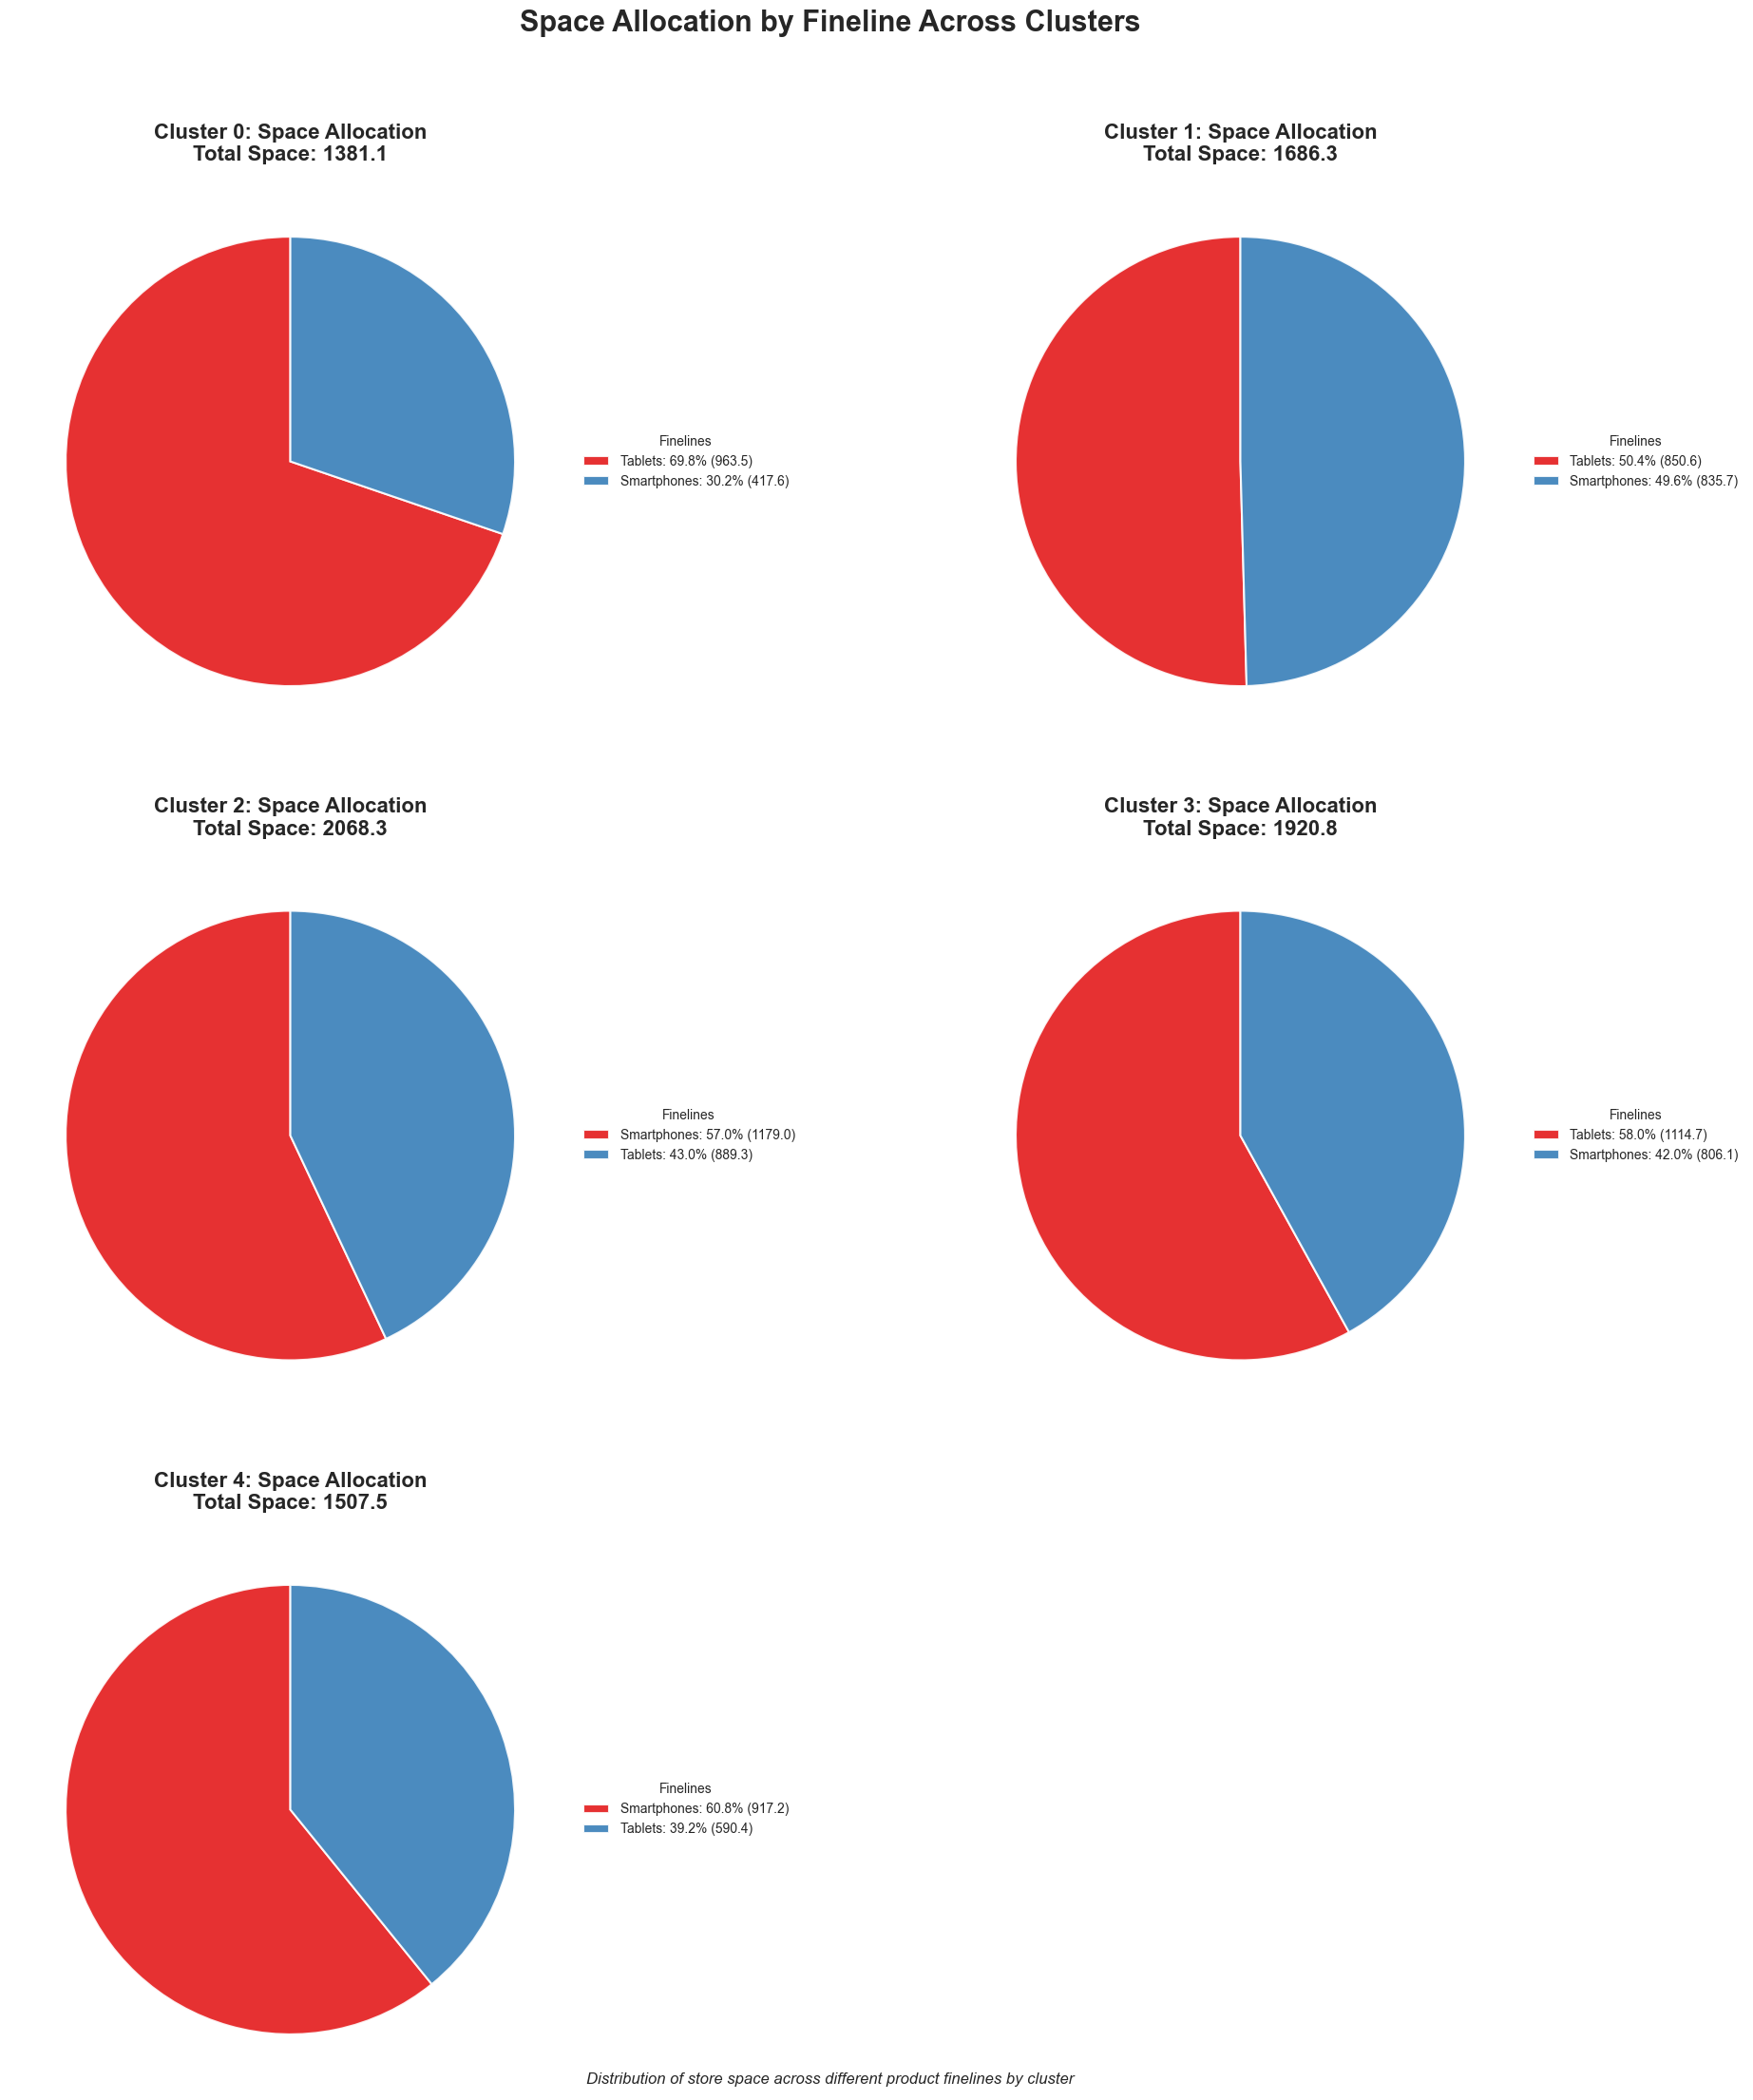

In [22]:
plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams.update({"axes.grid": False})
plt.rcParams["figure.facecolor"] = "white"

# Get unique clusters
cluster_ids = clusters["cluster"].unique()
num_clusters = len(cluster_ids)

# Calculate grid layout
cols = min(2, num_clusters)
rows = math.ceil(num_clusters / cols)

fig = plt.figure(figsize=(10 * cols, 7.5 * rows))

# Create color palette
distinct_colors = []
distinct_colors.extend(plt.cm.Set1.colors)
distinct_colors.extend(plt.cm.Dark2.colors)
distinct_colors.extend(plt.cm.tab10.colors)
distinct_colors.extend(plt.cm.Paired.colors[::2])
distinct_colors.extend(
    [
        "#FFA500",  # Orange
        "#00FFFF",  # Cyan
        "#FF00FF",  # Magenta
        "#FFFF00",  # Yellow
        "#800080",  # Purple
        "#008080",  # Teal
    ]
)

for i, cluster_id in enumerate(sorted(cluster_ids)):
    # Create subplot in the grid
    ax = fig.add_subplot(rows, cols, i + 1)

    # Filter data for this cluster
    cluster_data = clusters[clusters["cluster"] == cluster_id]

    # Extract fineline space allocation
    fineline_data = pd.DataFrame(
        {
            "fineline": cluster_data.columns[
                2:-1
            ],  # Skip cluster, store_area, and fineline_space
            "space": [
                cluster_data.iloc[0][fineline]
                for fineline in cluster_data.columns[2:-1]
            ],
        }
    )

    # Sort by space allocation (descending)
    fineline_data = fineline_data.sort_values("space", ascending=False)

    slice_colors = [
        distinct_colors[j % len(distinct_colors)] for j in range(len(fineline_data))
    ]

    # Create pie chart
    wedges, texts = ax.pie(
        fineline_data["space"],
        labels=None,
        startangle=90,
        colors=slice_colors,
        wedgeprops={"edgecolor": "white", "linewidth": 1.5, "alpha": 0.9},
        shadow=False,
    )

    # Calculate percentages for legend labels
    total_space = cluster_data.iloc[0]["store_area"]

    # Create custom legend labels with percentages and space
    legend_labels = [
        f"{row['fineline']}: {(row['space']/total_space)*100:.1f}% ({row['space']:.1f})"
        for _, row in fineline_data.iterrows()
    ]

    # Add legend outside the pie
    ax.legend(
        wedges,
        legend_labels,
        title="Finelines",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=10,
    )

    # Customize pie chart title
    ax.set_title(
        f"Cluster {cluster_id}: Space Allocation\nTotal Space: {total_space:.1f}",
        fontsize=16,
        fontweight="bold",
        pad=15,
    )

plt.tight_layout()

plt.subplots_adjust(top=0.90, wspace=0.2, hspace=0.2)

fig.suptitle(
    "Space Allocation by Fineline Across Clusters",
    fontsize=22,
    fontweight="bold",
    y=0.98,
)

plt.figtext(
    0.5,
    0.01,
    "Distribution of store space across different product finelines by cluster",
    ha="center",
    fontsize=12,
    fontstyle="italic",
)

plt.show()

## Section 6: Prepare Data for Optimization
This section prepares a DataFrame with product-by-cluster information to be used in the optimization process.
It calculates the optimization velocity, adds necessary product information, and computes the upper and lower bounds for each product.

In [23]:
# Create product dataframe with optimization velocity
updated_cluster_predictions["optimization_velocity"] = (
    unit_weight * updated_cluster_predictions["predicted_unit_velocity"]
    + dollar_weight * updated_cluster_predictions["predicted_dollar_velocity"]
)

# Add fineline information to updated_predictions
updated_cluster_predictions = updated_cluster_predictions.merge(
    product_store_sales[["product", "product_fineline"]].drop_duplicates(
        subset=["product"], keep="first"
    ),
    on="product",
    how="left",
)

# Add product area to updated_predictions
updated_cluster_predictions = updated_cluster_predictions.merge(
    product_store_space[["product", "product_area"]].drop_duplicates(
        subset=["product"], keep="first"
    ),
    on="product",
    how="left",
)

products = updated_cluster_predictions[
    [
        "cluster",
        "product",
        "product_fineline",
        "product_area",
        "predicted_unit_velocity",
        "optimization_velocity",
    ]
]

In [24]:
# Find the depth of each product position
product_store_space["number_of_facings"] = (
    product_store_space["total_horizontal_facing_quantity"]
    * product_store_space["total_vertical_facing_quantity"]
)
product_store_space["facing_depth"] = (
    product_store_space["shelf_capacity_quantity"]
    / product_store_space["number_of_facings"]
)

# Simplify position depth to be unique to a product. This can be elaborated to make it unique to a product/store combination.
store_product_depth = (
    product_store_space.groupby(["product"])["facing_depth"].mean().reset_index()
)

# Merge depth information with products
products = products.merge(store_product_depth, on=["product"], how="left")

In [25]:
# Find the ratio of the number of products sold per day to the depth of facings
products["product_ratio"] = (
    products["predicted_unit_velocity"] / products["facing_depth"] / 7
)  # 7 days in a week

products = products[
    [
        "cluster",
        "product",
        "product_fineline",
        "product_area",
        "product_ratio",
        "optimization_velocity",
    ]
]

# Round the product_ratio to the next integer
products["product_ratio"] = np.ceil(products["product_ratio"])

# Rename product_ratio as upper_bound - Here this can be changed for other business constraints
products.rename(columns={"product_ratio": "upper_bound"}, inplace=True)

# Create a column called lower_bound and set to 0 for now - Here this can be changed for other business constraints
products["lower_bound"] = 0

products

,cluster,product,product_fineline,product_area,upper_bound,optimization_velocity,lower_bound
0,0,LunaBook Pro,Smartphones,176.4180,2.0,1116.766935,0
1,0,LunaPhone Axis,Smartphones,67.9320,2.0,822.913066,0
2,0,LunaPhone Edge,Smartphones,237.2176,2.0,537.381075,0
3,0,LunaPhone Helios,Smartphones,109.4427,2.0,628.181855,0
4,0,LunaPhone Ion,Smartphones,117.7050,1.0,279.446308,0
...,...,...,...,...,...,...,...
95,4,LunaTab X,Tablets,171.4500,2.0,1231.38345,0
96,4,LunaTech Induction Cooktop,Tablets,55.7750,2.0,642.273202,0
97,4,LunaTech Pad,Tablets,52.6380,2.0,850.537322,0
98,4,LunaTech Slate,Tablets,78.6428,2.0,698.453294,0


## Section 6: Linear Optimization for Product Assortment
Our assortment optimization employs linear programming to maximize sales velocity while respecting space constraints. The key aspects of this approach include:

- **Objective function**: Maximize predicted sales velocity across the assortment
- **Space constraints**: Respect the available space in a typical store within the cluster
- **Product fineline balance**: Maintain appropriate allocation of space across product fineline categories
- **Diminishing returns**: Account for reduced incremental impact of adding multiple units of the same product

The optimization produces a recommended assortment for each cluster, specifying both the products to include and the optimal number of facings.


In [26]:
def optimize_assortment_with_varying_decay(products, clusters, max_units_per_product=3):
    cluster_assortments = []

    for _, cluster in clusters.iterrows():
        cluster_id = cluster["cluster"]
        total_space = cluster["store_area"]
        subsegment_space = cluster["fineline_space"]

        # Filter products for the current cluster
        cluster_products = products[products["cluster"] == cluster_id]

        # Create multiple decision variables for each product
        num_products = len(cluster_products)

        # Initialize coefficients and constraints
        c = []  # Objective coefficients
        A = []  # Constraint matrix
        b = []  # Constraint bounds

        # For each product, create multiple decision variables with product-specific diminishing returns
        for i in range(num_products):
            product_velocity = cluster_products.iloc[i]["optimization_velocity"]
            product_area = cluster_products.iloc[i]["product_area"]

            # Get product-specific decay rate
            decay_rate = cluster_products.iloc[i].get(
                "decay_rate", 0.5
            )  # Default to 0.5 if not specified - this can be further modeled.

            for unit in range(max_units_per_product):
                # Calculate product-specific diminishing velocity for each additional unit
                diminishing_factor = np.exp(-unit / decay_rate)
                c.append(
                    -product_velocity * diminishing_factor
                )  # Negative for maximization

        # Create constraints for total space
        total_space_row = []
        for i in range(num_products):
            product_area = cluster_products.iloc[i]["product_area"]
            for _ in range(max_units_per_product):
                total_space_row.append(product_area)

        A.append(total_space_row)
        b.append(total_space)

        # Create constraints for subsegment space
        for subsegment, max_space in subsegment_space.items():
            subsegment_row = []
            for i in range(num_products):
                product_area = cluster_products.iloc[i]["product_area"]
                is_in_subsegment = (
                    cluster_products.iloc[i]["product_fineline"] == subsegment
                )
                for _ in range(max_units_per_product):
                    subsegment_row.append(product_area * is_in_subsegment)

            A.append(subsegment_row)
            b.append(max_space)

        # Add ordering constraints to ensure logical selection
        for i in range(num_products):
            for unit in range(1, max_units_per_product):
                order_row = [0] * (num_products * max_units_per_product)
                prev_unit_pos = i * max_units_per_product + (unit - 1)
                curr_unit_pos = i * max_units_per_product + unit
                order_row[curr_unit_pos] = 1
                order_row[prev_unit_pos] = -1
                A.append(order_row)
                b.append(0)  # Current <= Previous

        # Bounds for each variable - using lower_bound and upper_bound for the first unit
        bounds = []
        for i in range(num_products):
            # First unit bounds are based on lower_bound and upper_bound
            lower_bound = cluster_products.iloc[i].get(
                "lower_bound", 0.0
            )  # Default to 0.0 if not specified
            upper_bound = cluster_products.iloc[i].get(
                "upper_bound", 1.0
            )  # Default to 1.0 if not specified
            bounds.append((lower_bound, upper_bound))  # First unit

            # Subsequent units have bounds of (0, 1)
            for _ in range(1, max_units_per_product):
                bounds.append((0, 1))  # Subsequent units

        # Solve the problem
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")

        if res.success:
            # Process results
            for i in range(num_products):
                product = cluster_products.iloc[i]["product"]
                # Count how many units were selected for this product
                units = sum(
                    np.round(
                        res.x[
                            i * max_units_per_product : (i + 1) * max_units_per_product
                        ]
                    )
                )

                # Add each selected product to the assortment with unit count
                if units > 0:
                    cluster_assortments.append(
                        {"cluster": cluster_id, "product": product, "units": int(units)}
                    )
        else:
            print(f"Optimization failed for cluster {cluster_id}")

    return pd.DataFrame(cluster_assortments)


# Optimize assortment for each store
cluster_assortments = optimize_assortment_with_varying_decay(products, clusters)

In [27]:
cluster_assortments.head()

,cluster,product,units
0,0,LunaPhone Axis,2
1,0,LunaPhone Nova,2
2,0,LunaPhone Spark,1
3,0,LunaTab Lite,1
4,0,LunaTab Max,2


### Store-Level Implementation of Cluster Recommendations

While optimization occurs at the cluster level, implementation happens at individual stores. This section translates cluster-level recommendations into store-specific actions by:

1. Identifying each store's cluster assignment
2. Comparing the store's current assortment with its cluster's optimized assortment
3. Generating specific "add" and "remove" recommendations for each store

This approach maintains the efficiency of cluster-based planning while providing actionable guidance for each location. The resulting recommendations balance operational simplicity with store-specific needs.

In [28]:
def generate_store_level_changes_based_on_clusters(
    cluster_assortments, product_store_data, store_to_cluster
):
    # Create empty list to store the results
    changes = []

    # For each store, compare its current assortment to its cluster's recommended assortment
    for store in product_store_data["store"].unique():
        # Get the cluster this store belongs to
        cluster = store_to_cluster[store]

        # Get current products for this store
        current_products = set(
            product_store_data[(product_store_data["store"] == store)][
                "product"
            ].unique()
        )

        # Get recommended products for this store's cluster
        cluster_recommendations = cluster_assortments[
            cluster_assortments["cluster"] == cluster
        ]
        recommended_products = set(cluster_recommendations["product"])

        # Find products to add and remove
        products_to_add = recommended_products - current_products
        products_to_remove = current_products - recommended_products

        # Add details for products to add
        for product in products_to_add:
            units = cluster_recommendations[
                cluster_recommendations["product"] == product
            ]["units"].values[0]
            changes.append(
                {
                    "store": store,
                    "cluster": cluster,
                    "product": product,
                    "action": "Add",
                    "units": units,
                }
            )

        # Add details for products to remove
        for product in products_to_remove:
            changes.append(
                {
                    "store": store,
                    "cluster": cluster,
                    "product": product,
                    "action": "Remove",
                    "units": 0,
                }
            )

    changes_df = pd.DataFrame(changes)

    # If there are no changes, return an empty DataFrame with the right columns
    if len(changes_df) == 0:
        return pd.DataFrame(columns=["store", "cluster", "product", "action", "units"])

    changes_df = changes_df.sort_values(["store", "action", "product"])

    return changes_df


# Generate the store-level assortment changes based on cluster recommendations
store_level_changes = generate_store_level_changes_based_on_clusters(
    cluster_assortments, product_store_data, store_to_cluster
)

store_level_changes.head(20)

,store,cluster,product,action,units
0,STORE 10225,4,LunaPhone Helios,Add,2
3,STORE 10225,4,LunaPhone Muse,Add,2
4,STORE 10225,4,LunaPhone Spark,Add,2
1,STORE 10225,4,LunaTech Pad,Add,2
2,STORE 10225,4,LunaTech Slate,Add,2
5,STORE 10225,4,LunaBook Pro,Remove,0
6,STORE 10225,4,LunaPhone Ion,Remove,0
7,STORE 10225,4,LunaPhone Pulse,Remove,0
9,STORE 10225,4,LunaTab Horizon,Remove,0
11,STORE 10225,4,LunaTab Mini,Remove,0


In [29]:
store_level_changes[store_level_changes["store"] == "STORE 10225"]

,store,cluster,product,action,units
0,STORE 10225,4,LunaPhone Helios,Add,2
3,STORE 10225,4,LunaPhone Muse,Add,2
4,STORE 10225,4,LunaPhone Spark,Add,2
1,STORE 10225,4,LunaTech Pad,Add,2
2,STORE 10225,4,LunaTech Slate,Add,2
5,STORE 10225,4,LunaBook Pro,Remove,0
6,STORE 10225,4,LunaPhone Ion,Remove,0
7,STORE 10225,4,LunaPhone Pulse,Remove,0
9,STORE 10225,4,LunaTab Horizon,Remove,0
11,STORE 10225,4,LunaTab Mini,Remove,0
